Import Error on Tables, using fixed turbidity - not a major problem


,poa_global,poa_direct,poa_diffuse,poa_sky_diffuse,poa_ground_diffuse,PV_Forecasting,Actual_PV_power_W,Forecasting_Solcast
2019-08-15 00:00:00+02:00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-08-15 01:00:00+02:00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-08-15 02:00:00+02:00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-08-15 03:00:00+02:00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-08-15 04:00:00+02:00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2019-08-15 05:00:00+02:00,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.634921,0.000000
2019-08-15 06:00:00+02:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.360000,17.633618
2019-08-15 07:00:00+02:00,282.778420,239.079076,43.699344,43.115473,0.583871,717.507824,500.900000,223.971758
2019-08-15 08:00:00+02:00,603.870290,509.205756,94.664533,93.088510,1.576023,1532.230279,1139.985294,671.586052
2019-08-15 09:00:00+02:00,846.035091,714.721978,131.313114,128.845764,2.467349,2146.687139,1301.852941,1061.643479


No handles with labels found to put in legend.


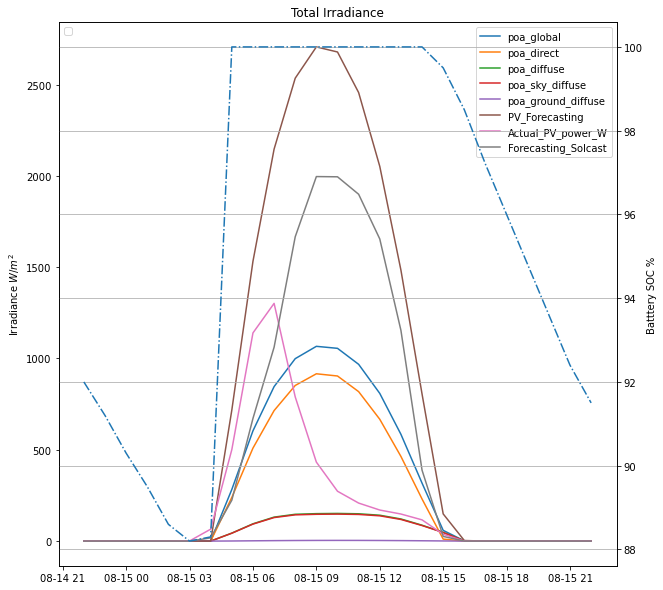

In [1]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pvlib
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib.iotools import read_tmy3
from pvlib.solarposition import get_solarposition
import pandas as pd 
import matplotlib.pyplot as plt
import datetime
import sys 
from pylab import rcParams
rcParams['figure.figsize'] = 10,10

#Set
start_date =  "8/15/2019 0:00"
end_date = "8/16/2019 0:00"
sys.path.append(os.path.dirname(os.getcwd()))
df = pd.read_csv("../data/microgrid_processed_august.csv")
df.index = pd.to_datetime(df['timestamp'])


# df_sol = pd.read_csv("../data/solar.csv")
# df_sol.index = pd.to_datetime(df_sol['Time (2019!)'],format='%d/%m/%Y %H:%M')
# df_sol.index = df_sol.index + pd.DateOffset(years=12)

#Pv Info
lat = -2.483535
long = 29.523457

#https://www.daftlogic.com/sandbox-google-maps-find-altitude.htm
height = 2139

#typical temperature between 15 and 28 yearly, taking 22 as average
typ_temp = 22

#Efficienct
effic = 0.155

#Area m2
area = 16.37

#Surface
surf_tilt = 15
surf_az = 119.5 #It might be more like 119.5
   
clear_index = 0.634

Clearness_Index=[0.482,0.482,0.466,0.464,0.484,0.566,0.587,0.545,0.521,0.49,0.465,0.481]

tus = Location(lat, long, "Africa/Kigali", height, 'Kigeme')

times = pd.date_range(start=start_date, end=end_date, freq='1H', tz=tus.tz)

try:
    cs = tus.get_clearsky(times, model='ineichen')  # ineichen with climatology table by default
except ImportError:
    print("Import Error on Tables, using fixed turbidity - not a major problem")
    cs = tus.get_clearsky(times,model="ineichen", linke_turbidity=3)
    
#cs['dhi']= cs['dhi']*clear_index
#cs['dni']= cs['dni']*clear_index
#cs['ghi']= cs['ghi']*clear_index

sun_pos = get_solarposition(cs.index, lat, long,altitude=height, pressure=None,method='nrel_numpy', temperature=typ_temp)

airmass = None
#airmass = tus.get_airmass(cs.index,sun_pos[['apparent_zenith','zenith']])


#\[I_{tot} = I_{beam} + I_{sky} + I_{ground}\]
total_irrad = pvlib.irradiance.get_total_irradiance(surf_tilt, surf_az, sun_pos['zenith'], sun_pos['azimuth'], cs['dni'], cs['ghi'], cs['dhi'], DNI_ET=None, AM=None,airmass=airmass, albedo=0.25, surface_type="grass", model='klucher', model_perez='allsitescomposite1990')

total_irrad['PV_Forecasting'] = total_irrad['poa_global']*effic*area

df_cons = df[start_date:end_date]["PV_power_W"].to_frame()
df_cons.index = total_irrad.index
total_irrad['Actual_PV_power_W'] = df_cons

df_bat = df[start_date:end_date]["State_of_charge"].to_frame()
df_bat.index = total_irrad.index

df_cons = df[start_date:end_date]["Pot_PV_power_W"].to_frame()
df_cons.index = total_irrad.index
total_irrad['Forecasting_Solcast'] = df_cons

# df_sol = df_sol[start_date:end_date]["In-plane array Incident Solar"].to_frame() #Global Solar GHI
# df_sol.index = total_irrad.index
# total_irrad['Solcast_v2'] = df_sol["In-plane array Incident Solar"]*effic*area*1000

display(total_irrad)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(total_irrad.index, total_irrad)
ax2 = ax.twinx()
ax2.plot(df_bat,"-.")
ax2.legend(loc='upper left')
ax.set_ylabel('Irradiance $W/m^2$');
ax2.set_ylabel('Batttery SOC %');
# ax.set_ylim([0, 300])
plt.grid()
ax.legend(total_irrad.columns.values,loc='upper right')
plt.title('Total Irradiance');      
plt.show()
#total_irrad.to_csv("pv_forecast_test.csv")

No handles with labels found to put in legend.


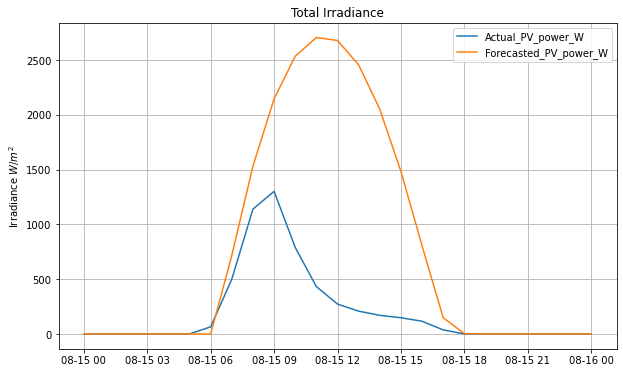

No handles with labels found to put in legend.


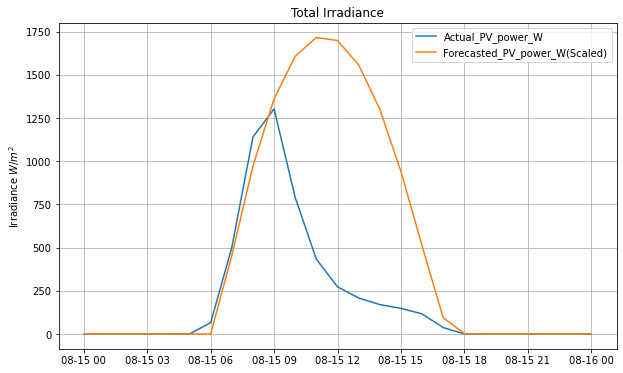

,Actual_PV_power_W,PV_Forecasting,PV_Forecasting_Scaled
2019-08-15 00:00:00+02:00,0.000000,0.000000,0.000000
2019-08-15 01:00:00+02:00,0.000000,0.000000,0.000000
2019-08-15 02:00:00+02:00,0.000000,0.000000,0.000000
2019-08-15 03:00:00+02:00,0.000000,0.000000,0.000000
2019-08-15 04:00:00+02:00,0.000000,0.000000,0.000000
2019-08-15 05:00:00+02:00,0.634921,0.000000,0.000000
2019-08-15 06:00:00+02:00,65.360000,0.000000,0.000000
2019-08-15 07:00:00+02:00,500.900000,717.507824,454.899961
2019-08-15 08:00:00+02:00,1139.985294,1532.230279,971.433997
2019-08-15 09:00:00+02:00,1301.852941,2146.687139,1360.999646


In [2]:
rcParams['figure.figsize'] = 10,6
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(total_irrad.index, total_irrad["Actual_PV_power_W"])
ax.plot(total_irrad.index, total_irrad["PV_Forecasting"])
ax2.legend(loc='upper left')
ax.set_ylabel('Irradiance $W/m^2$');
plt.grid()
ax.legend(['Actual_PV_power_W','Forecasted_PV_power_W'],loc='upper right')
plt.title('Total Irradiance');      
plt.show()
#total_irrad.to_csv("pv_forecast_test.csv")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(total_irrad.index, total_irrad["Actual_PV_power_W"])
ax.plot(total_irrad.index, total_irrad["PV_Forecasting"]*clear_index)
ax2.legend(loc='upper left')
ax.set_ylabel('Irradiance $W/m^2$');
plt.grid()
ax.legend(['Actual_PV_power_W','Forecasted_PV_power_W(Scaled)'],loc='upper right')
plt.title('Total Irradiance');      
plt.show()
